# Replicate Fine-Tuning Tutorial
This notebook walks you through fine-tuning image models (FLUX.1, SDXL) with Replicate’s API. We’ll:
- Load API keys securely from `.env`
- Prepare training data (zip of images)
- Launch fine-tuning jobs via the Python client
- Monitor training progress and generate samples

**Key Concepts**:
- Fine-tuning lets you adapt pre-trained image-generation models to new subjects or styles using just a handful of images (FLUX.1: as few as 2–10)
- Replicate supports FLUX.1 and SDXL via API and web. FLUX.1 uses LoRA (Lightweight, fast, parameter-efficient) 
- Training pipeline includes preprocessing (e.g., SwinIR, BLIP, CLIPSeg for SDXL) 


In [33]:
import os
from dotenv import load_dotenv
import replicate

# Load API key
load_dotenv()
REPLICATE_API_TOKEN = os.getenv("REPLICATE_API_TOKEN")
assert REPLICATE_API_TOKEN, "Set REPLICATE_API_TOKEN in .env file"
replicate_client = replicate.Client(api_token=REPLICATE_API_TOKEN)


## 1. Prepare Training Data
- Collect 5–20 images representing your subject/style (high quality, varied angles/lighting)
- Zip them: `zip -r training_images.zip your_folder/`


In [19]:
# Example: Ensure training_images.zip exists
ZIP_PATH = "training_images.zip"
assert os.path.isfile(ZIP_PATH), f"Place your zip at {ZIP_PATH}"

## 2. Launch FLUX.1 Fine-Tuning
Use LoRA via Replicate API:
- Choose or create a `trigger_word` (nonsense or unique token).
- Launch training job.

In [37]:
try:
    # Try to get current user info through endpoint
    import requests
    headers = {"Authorization": f"Token {REPLICATE_API_TOKEN}"}
    response = requests.get("https://api.replicate.com/v1/account", headers=headers)
    if response.status_code == 200:
        user_data = response.json()
        username = user_data.get("username", user_data.get("name"))
    else:
        print(f"\n API request failed with status: {response.status_code}")
        username = "your_username"  # Set a fallback username
except Exception as e:
    print(f"Error: {e}")
    username = "your_username"  # Set a fallback username

# Set up destination name with your username
flux_destination = f"{username}/flux-my-finetune-v2"

print(f"\n📋 FLUX destination will be: {flux_destination}")


📋 FLUX destination will be: devonsunml/flux-my-finetune-v2


In [ ]:
# Create the destination model first if it doesn't exist
try:
    print(f"Creating model: {flux_destination}")
    model = replicate_client.models.create(
        owner=username,
        name="flux-my-finetune-v2",
        visibility="private",
        description="Fine-tuned FLUX model",
        hardware="gpu-t4" 
    )
    print(f"✅ Model created: {model.name}")
except Exception as e:
    print(f"Error: {e}")

Fine Tuning the model with your own dataset

In [29]:
try:
    training = replicate_client.trainings.create(
        version="replicate/fast-flux-trainer:f463fbfc97389e10a2f443a8a84b6953b1058eafbf0c9af4d84457ff07cb04db",
        input={
            "input_images": open(ZIP_PATH, "rb"), 
            "trigger_word": "MYTOK",
            "steps": 1000
        },
        destination=flux_destination
    )
    print("✅ Training started successfully!")
    print("Training ID:", training.id)
    print("You can monitor training at:", training.urls.get)
    
except Exception as e:
    print(f"Error {e}")

✅ Training started successfully!
Training ID: 7v0r4sswjxrm80crhmd92axe2m
You can monitor training at: <built-in method get of dict object at 0x117a1a9c0>


## 3. Monitor Progress & Generate Samples
Use the `training.status` or `training.logs` to monitor. Once done, invoke the fine-tuned model like any other Replicate model.

In [31]:
# Polling loop (example)
import time

# Store training job
training_jobs = []
if 'training' in locals():
    training_jobs.append(training)

for job in training_jobs:
    print(f"Polling {job.id}...")
    while True:
        job = replicate_client.trainings.get(job.id)
        print(f"Status: {job.status}")
        if job.status in ["succeeded", "failed", "canceled"]:
            break
        time.sleep(30)  # Check every 30 seconds
    print(f"Job {job.id} finished with status {job.status}")
    
    if job.status == "succeeded":
        print(f"Training completed! View results at: {job.urls.get}")
        print("Note: To use the trained model, you'll need to:")
        print("1. Go to the training URL above")
        print("2. Create a model from the training results")
        print("3. Use the new model ID for generation")
    else:
        print(f"Training failed or was canceled")

Polling 7v0r4sswjxrm80crhmd92axe2m...
Status: succeeded
Job 7v0r4sswjxrm80crhmd92axe2m finished with status succeeded
Training completed! View results at: <built-in method get of dict object at 0x117a1f800>
Note: To use the trained model, you'll need to:
1. Go to the training URL above
2. Create a model from the training results
3. Use the new model ID for generation


Image URL: https://replicate.delivery/xezq/dd4p70uV5X4TL1mJCmFyPdcr5MLlUZzYOzbwYOIf7vwuJkkKA/out-0.webp


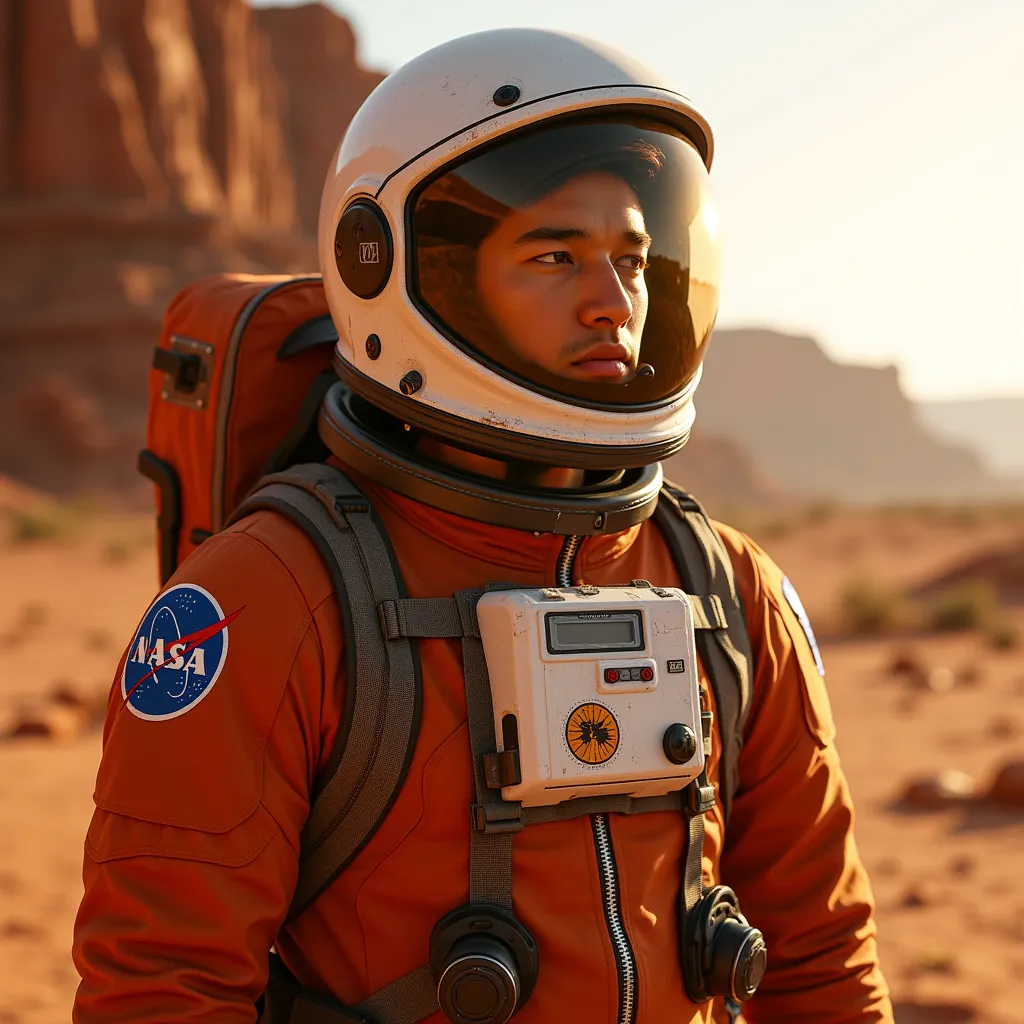

In [44]:
# Generate an image of yourself wearing a space suit using your fine-tuned model
prompt = "A realistic photo of Devon wearing a space suit on Mars, cinematic lighting, astronaut helmet, NASA patch, high detail"
output = replicate.run(
    "devonsunml/flux-my-finetune-v2:1c68fbecae650b8a0dd9e4ea7f38f9c18cba1b9fc4af1077d0a0c9fe403db98a",
    input={
        "prompt": prompt,
        "model": "dev",
        "go_fast": False,
        "lora_scale": 1,
        "megapixels": "1",
        "num_outputs": 1,
        "aspect_ratio": "1:1",
        "output_format": "webp",
        "guidance_scale": 3,
        "output_quality": 80,
        "prompt_strength": 0.8,
        "extra_lora_scale": 1,
        "num_inference_steps": 28
    }
)

# To access the file URL:
img_url = output[0]
print("Image URL:", img_url)

import requests
from IPython.display import Image, display
img_data = requests.get(img_url).content
display(Image(data=img_data, width=512, height=512))

## 4. Tips & Next Steps
- Choose non-common trigger words to avoid false activations.
- Adjust `steps`, `batch size`, `resolution` as needed.
- Fine-tuned models boot fast (cold start under 1 s).
- Try mixing styles or subjects across multiple fine-tunes.

Enjoy fine-tuning your creative models!